In [29]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

learning_rate = 0.1
training_epochs = 5000
display_step = 200
n_idle_epochs = 1000
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=n_idle_epochs, min_delta=0.00001)

def scheduler(epoch, lr):
    if lr <= 0.005:
        return lr
    if epoch % 200 == 0:
        return lr * 0.8
    else:
        return lr
reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

class NEPOCHLogger(tf.keras.callbacks.Callback):
    def __init__(self, per_epoch=200):
        super(NEPOCHLogger, self).__init__()
        self.seen = 0
        self.per_epoch = per_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.per_epoch == 0:
            print('Epoch {}, loss {:.8f}, val_loss {:.8f}'.format(epoch, logs['loss'], logs['val_loss']))


log_display = NEPOCHLogger(per_epoch=display_step)
train_data = pd.read_csv(r'two_spiral_train_data.txt', header=None, sep='\s+')
test_data = pd.read_csv(r'two_spiral_test_data.txt', header=None, sep='\s+')
# train_data['class_0'] = train_data[2].apply(lambda x: 1 if x == 0 else 0)
# train_data['class_1'] = train_data[2].apply(lambda x: 1 if x == 1 else 0)
# test_data['class_0'] = test_data[2].apply(lambda x: 1 if x == 0 else 0)
# test_data['class_1'] = test_data[2].apply(lambda x: 1 if x == 1 else 0)


train_X = tf.convert_to_tensor(np.asarray(train_data.iloc[:, 0:2]))
train_y = tf.convert_to_tensor(np.asarray(train_data.iloc[:, 2]))
test_X = tf.convert_to_tensor(np.asarray(test_data.iloc[:, 0:2]))
test_y = tf.convert_to_tensor(np.asarray(test_data.iloc[:, 2]))

model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=100, input_shape=(2,), activation='relu'),
    tf.keras.layers.Dense(units=50, activation='relu'),
    tf.keras.layers.Dense(units=50, activation='relu'),
    tf.keras.layers.Dense(units=50, activation='relu'),
    tf.keras.layers.Dense(units=50, activation='relu'),
    tf.keras.layers.Dense(units=30, activation='relu'),
    tf.keras.layers.Dense(units=15, activation='relu'),
    tf.keras.layers.Dense(units=10, activation='relu'),
    tf.keras.layers.Dense(units=5, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='swish')
])

optimizer = tf.keras.optimizers.SGD(learning_rate)

model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])


In [51]:
history = model.fit(train_X, train_y, epochs=training_epochs, validation_split=0.1, verbose=0, callbacks=[early_stopping, log_display, reduce_lr])
print("Train Finished!")

print('Final train loss: %10.8f' % history.history["loss"][-1])
print('Final test loss: %10.8f' % model.evaluate(test_X, test_y, verbose=0)[0])
y_hat_train = model.predict(train_X, verbose=0)
y_hat_test = model.predict(test_X, verbose=0)
abs_train_error = np.abs((tf.convert_to_tensor(np.reshape(y_hat_train, (300,))) - tf.cast(train_y, tf.float32)).numpy())
abs_test_error = np.abs((tf.convert_to_tensor(np.reshape(y_hat_test, (300,))) - tf.cast(test_y, tf.float32)).numpy())
print('total number of test samples: %d' % len(test_y))
print('number of train samples with absolute error >= 0.1: %d' % len(abs_train_error[abs_train_error >= 0.10]))
print('number of train samples with absolute error >= 0.5: %d' % len(abs_train_error[abs_train_error >= 0.50]))
print('number of test samples with absolute error >= 0.1: %d' % len(abs_test_error[abs_test_error >= 0.10]))
print('number of test samples with absolute error >= 0.5: %d' % len(abs_test_error[abs_test_error >= 0.50]))
with open('abs_test_error.txt', 'w') as f:
    for item in abs_test_error:
        f.write("%s\n" % item)

Epoch 0, loss 0.00000431, val_loss 0.00145118
Epoch 200, loss 0.00000427, val_loss 0.00144820
Epoch 400, loss 0.00000423, val_loss 0.00144789
Epoch 600, loss 0.00000420, val_loss 0.00144661
Epoch 800, loss 0.00000416, val_loss 0.00144516
Epoch 1000, loss 0.00000412, val_loss 0.00144295
Epoch 1200, loss 0.00000409, val_loss 0.00144156
Epoch 1400, loss 0.00000406, val_loss 0.00144048
Epoch 1600, loss 0.00000403, val_loss 0.00144050
Epoch 1800, loss 0.00000399, val_loss 0.00143756
Train Finished!
Final train loss: 0.00000399
Final test loss: 0.00611020
total number of test samples: 300
number of train samples with absolute error >= 0.1: 1
number of train samples with absolute error >= 0.5: 0
number of test samples with absolute error >= 0.1: 27
number of test samples with absolute error >= 0.5: 1


In [42]:
class_0_area, class_1_area = {}, {}
for x in np.arange(-10, 10, 0.066):
    for y in np.arange(-10, 10, 0.066):
        if model.predict([[x, y]], verbose=0)[0][0] > 0.5:
            class_1_area.setdefault('x', []).append(x)
            class_1_area.setdefault('y', []).append(y)
        else:
            class_0_area.setdefault('x', []).append(x)
            class_0_area.setdefault('y', []).append(y)

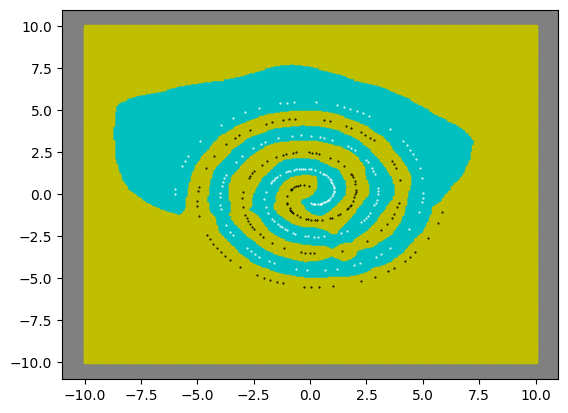

In [54]:
class_0, class_1 = {}, {}
# for X, y in zip(np.concatenate([train_X.numpy(), test_X.numpy()], 0), np.concatenate([train_y.numpy(), test_y.numpy()], 0)):
for X, y in zip(train_X.numpy(), train_y.numpy()):
    if y == 0:
        class_0.setdefault('x', []).append(X[0])
        class_0.setdefault('y', []).append(X[1])
    else:
        class_1.setdefault('x', []).append(X[0])
        class_1.setdefault('y', []).append(X[1])
plt.axes().set_facecolor('gray')
plt.plot(class_0_area['x'], class_0_area['y'], 'cs', markersize=2, label='class 0 area')
plt.plot(class_1_area['x'], class_1_area['y'], 'ys', markersize=2, label='class 1 area')
plt.plot(class_0['x'], class_0['y'], 'wo', markersize=0.5, label='class 0')
plt.plot(class_1['x'], class_1['y'], 'o', markersize=0.5, color='#000000', label='class 1')
plt.show()